In [3]:
### Importing necessary libraries
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime, timedelta
import joblib
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from custom_rf import RandomForest

In [4]:

# Function to calculate Vapor Pressure Deficit (VPD)
def calculate_vpd(temperature_celsius, relative_humidity):
    """
    Calculates Vapor Pressure Deficit (VPD) in kPa.
    Source: https://www.fruit.wisc.edu/VPD-and-Relative-Humidity-Calculations/
    """
    if temperature_celsius is None or relative_humidity is None:
        return None

    # Saturation Vapor Pressure (Es) in kPa
    # Magnus-Tetens formula (valid for T > 0 deg C)
    Es = 0.6108 * np.exp((17.27 * temperature_celsius) / (temperature_celsius + 237.3))

    # Actual Vapor Pressure (Ea) in kPa
    Ea = (relative_humidity / 100) * Es

    # Vapor Pressure Deficit (VPD) in kPa
    VPD = Es - Ea
    return VPD


### Data Cleaning and Preparation

In [ ]:
# Cell 3: Data Cleaning and Preparation
import pandas as pd
import numpy as np # Ensure numpy is imported for array([])
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

try:
    df = pd.read_csv('fire_dataset_enriched.csv')

    # Handle missing values by dropping rows
    initial_rows = df.shape[0]
    df = df.dropna()
    rows_after_dropna = df.shape[0]
    print(f"Missing values handled. {initial_rows - rows_after_dropna} rows dropped.")

    # Drop non-numeric or non-useful columns for model training
    # Check if 'acq_date' exists before dropping to prevent KeyError
    if 'acq_date' in df.columns:
        df = df.drop(columns=['acq_date'])
    else:
        print("Warning: 'acq_date' column not found, skipping drop.")

    # Define features (X) and target (y)
    # ENSURE X AND Y ARE NUMPY ARRAYS HERE BY ADDING .values
    X = df.drop(columns=['fire_occurred']).values # X is now a NumPy array
    y = df['fire_occurred'].values              # y is now a NumPy array

    # Train-Test Split (80-20) - train_test_split handles NumPy arrays well
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale the features - StandardScaler takes NumPy arrays
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) # Returns NumPy array
    X_test_scaled = scaler.transform(X_test)     # Returns NumPy array

    # Save the scaler for future use in manual predictions
    joblib.dump(scaler, 'scaler.pkl')

    # Save test set - Ensure this block is present
    # For saving, we need X_test as a DataFrame, so we recreate it temporarily if needed
    # Or, if you want to save the original unscaled test data
    # Let's use the unscaled X_test (which is a NumPy array from the split) and convert it back for saving
    test_df_to_save = pd.DataFrame(X_test, columns=df.drop(columns=['fire_occurred']).columns) # Recreate DataFrame for saving
    test_df_to_save["fire_occurred"] = y_test
    test_df_to_save.to_csv("fire_test_dataset.csv", index=False)
    print("Test dataset saved as fire_test_dataset.csv")

    print("Data cleaning and splitting complete.")
    print("X_train_scaled shape:", X_train_scaled.shape)
    print("X_test_scaled shape:", X_test_scaled.shape)

except FileNotFoundError:
    print("Error: 'fire_dataset_enriched.csv' not found. Please run previous cells to generate it.")
    X_train_scaled, X_test_scaled, y_train, y_test = np.array([]), np.array([]), np.array([]), np.array([])
except Exception as e:
    print(f"An error occurred during data cleaning and preparation: {e}")
    X_train_scaled, X_test_scaled, y_train, y_test = np.array([]), np.array([]), np.array([]), np.array([])

Missing values handled. 8 rows dropped.
Test dataset saved as fire_test_dataset.csv
Data cleaning and splitting complete.
X_train_scaled shape: (793, 8)
X_test_scaled shape: (199, 8)


### Random Forest from Scratch Implementation

In [6]:
# Gini Impurity Function
def gini(y):
    counts = Counter(y)
    impurity = 1 - sum((c / len(y))**2 for c in counts.values())
    return impurity

# Dataset Split
def split_dataset(X, y, feature_index, threshold):
    left_indices = [i for i in range(len(X)) if X[i][feature_index] <= threshold]
    right_indices = [i for i in range(len(X)) if X[i][feature_index] > threshold]
    return (X[left_indices], y[left_indices]), (X[right_indices], y[right_indices])

# Best Split Calculation
def best_split(X, y, features):
    best_gain = 0
    best_feature, best_threshold = None, None
    current_gini = gini(y)

    for feature_idx in features:
        thresholds = np.unique(X[:, feature_idx])
        for t in thresholds:
            (X_left, y_left), (X_right, y_right) = split_dataset(X, y, feature_idx, t)
            
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            
            gain = current_gini - (\
                (len(y_left)/len(y)) * gini(y_left) +\
                (len(y_right)/len(y)) * gini(y_right)\
            )
            
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = t
    return best_feature, best_threshold

# Tree Node Class
class TreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value # Class label for leaf node

    def is_leaf(self):
        return self.value is not None

# Build Decision Tree
def build_tree(X, y, depth=0, max_depth=10, min_samples=5, num_features=None):
    # Stop splitting if conditions are met
    if len(set(y)) == 1 or len(y) < min_samples or depth >= max_depth:
        # Return leaf node with most common class
        return TreeNode(value=Counter(y).most_common(1)[0][0])

    n_features = X.shape[1]
    # Select a subset of features for Random Forest (feature bagging)
    features_to_consider = np.random.choice(n_features, num_features or n_features, replace=False)
    
    best_feat, best_thresh = best_split(X, y, features_to_consider)

    # If no split improves Gini impurity, make it a leaf node
    if best_feat is None:
        return TreeNode(value=Counter(y).most_common(1)[0][0])

    (X_left, y_left), (X_right, y_right) = split_dataset(X, y, best_feat, best_thresh)
    
    # Recursively build left and right sub-trees
    left_branch = build_tree(X_left, y_left, depth + 1, max_depth, min_samples, num_features)
    right_branch = build_tree(X_right, y_right, depth + 1, max_depth, min_samples, num_features)

    return TreeNode(feature=best_feat, threshold=best_thresh, left=left_branch, right=right_branch)

# Tree Prediction
def predict_tree(x, tree):
    if tree.is_leaf():
        return tree.value
    
    # Handle potential None for tree.feature (if prediction on data with less features than training)
    if tree.feature is None or tree.feature >= len(x):
        # Fallback to majority class of this node if feature is invalid
        return tree.value if tree.value is not None else 0 # Or raise error
    
    if x[tree.feature] <= tree.threshold:
        return predict_tree(x, tree.left)
    else:
        return predict_tree(x, tree.right)

# Random Forest Class
class RandomForest:
    def __init__(self, n_trees=100, max_depth=10, min_samples=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_features_sqrt = int(np.sqrt(X.shape[1])) # Features to consider at each split
        for _ in range(self.n_trees):
            # Bootstrap sampling
            indices = np.random.choice(len(X), len(X), replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            
            # Build a tree
            tree = build_tree(X_sample, y_sample, max_depth=self.max_depth, 
                              min_samples=self.min_samples, num_features=n_features_sqrt)
            self.trees.append(tree)

    def predict(self, X):
        # Get predictions from all trees
        tree_preds = np.array([[predict_tree(x, tree) for tree in self.trees] for x in X])
        # Majority vote for final prediction
        return [Counter(row).most_common(1)[0][0] for row in tree_preds]

print("Random Forest implementation loaded.")

Random Forest implementation loaded.


In [7]:
from custom_rf import RandomForest

In [ ]:
# : Model Training and Evaluation

if X_train_scaled.size > 0:
    # Train the Random Forest model
   
    forest = RandomForest(n_trees=100, max_depth=10, min_samples=5) # Increased n_trees for better performance
    print("Training Random Forest model...")
    forest.fit(X_train_scaled, y_train)
    print("Training complete.")

    # Make predictions and evaluate
    predictions = forest.predict(X_test_scaled)

    # Accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"\nAccuracy of Random Forest (from scratch): {accuracy:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, predictions)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Classification Report
    class_report = classification_report(y_test, predictions)
    print("\nClassification Report:")
    print(class_report)

    # Save the trained model
    joblib.dump(forest, 'random_forest_final_model.pkl')
    print("Random Forest model saved as 'random_forest_final_model.pkl'")
else:
    print("Skipping model training and evaluation: Training data not available.")

Training Random Forest model...
Training complete.

Accuracy of Random Forest (from scratch): 0.8995

Confusion Matrix:
[[86 14]
 [ 6 93]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.90       100
           1       0.87      0.94      0.90        99

    accuracy                           0.90       199
   macro avg       0.90      0.90      0.90       199
weighted avg       0.90      0.90      0.90       199

Random Forest model saved as 'random_forest_final_model.pkl'


In [ ]:
# Cell 6: Manual Prediction Function with Automatic VPD Calculation


import pandas as pd
import joblib
import numpy as np # Needed for array operations in predict_manual_input

try:
    scaler = joblib.load('scaler.pkl')
    model = joblib.load('random_forest_final_model.pkl')
    print("Scaler and Random Forest model loaded for manual prediction.")
except FileNotFoundError:
    print("Error: 'scaler.pkl' or 'random_forest_final_model.pkl' not found. Please run previous cells to train and save them.")
    scaler = None
    model = None

if scaler and model:
   
    feature_names_for_manual_input = [
        'latitude', 'longitude', 'temperature', 'humidity',
        'wind_speed', 'precipitation', 'elevation', 'vpd'
    ]

    def predict_manual_input_interactive():
        """
        Interactively takes manual inputs from the user and makes a fire prediction.
        VPD is automatically calculated from temperature and humidity.
        """
        print("\nEnter parameters for prediction:")
        
        input_values = {}
        # List of features to ask the user for (VPD is calculated, not asked)
        features_to_ask = [
            'latitude', 'longitude', 'temperature', 'humidity',
            'wind_speed', 'precipitation', 'elevation'
        ]

        for feature in features_to_ask:
            while True:
                try:
                    val = float(input(f"Enter {feature}: "))
                    input_values[feature] = val
                    break
                except ValueError:
                    print("Invalid input. Please enter a numerical value.")
        
        # Automatically calculate VPD
        temperature = input_values.get('temperature')
        humidity = input_values.get('humidity')
        vpd = calculate_vpd(temperature, humidity) # Make sure calculate_vpd is defined (e.g., from Cell 1)
        
        # Add VPD to the dictionary
        input_values['vpd'] = vpd

        # Create a DataFrame for a single prediction, ensuring column order matches training data
        # Convert the dictionary to a list of values in the correct order
        ordered_input = [input_values[feat] for feat in feature_names_for_manual_input]
        input_df = pd.DataFrame([ordered_input], columns=feature_names_for_manual_input)

        # Convert to numpy array and scale
        input_scaled = scaler.transform(input_df.values)

        # Make prediction
        prediction = model.predict(input_scaled)[0] # [0] because predict returns a list

        return "FIRE" if prediction == 1 else "NO FIRE"

    print("\n--- Interactive Manual Input Prediction ---")
    predicted_fire = predict_manual_input_interactive()
    print(f"\n Prediction for given input: {predicted_fire}")

else:
    print("Manual prediction function not available due to missing scaler or model. Please run previous cells to train and save them.")

Scaler and Random Forest model loaded for manual prediction.

--- Interactive Manual Input Prediction ---

Enter parameters for prediction:


Enter latitude:  12
Enter longitude:  12
Enter temperature:  12
Enter humidity:  12
Enter wind_speed:  12
Enter precipitation:  12
Enter elevation:  12



🔥 Prediction for given input: NO FIRE


Enter latitude:  145
Enter longitude:  67
Enter temperature:  80
Enter humidity:  46
Enter wind_speed:  67
Enter precipitation:  80
Enter elevation:  1467



🔥 Prediction for given input: FIRE


In [13]:
 # Example usage
    # Example input data:
    # Be careful with the data types and order here.
    # Replace with actual values for testing
    # example_input = {
    #     'latitude': 27.5,
    #     'longitude': 85.0,
    #     'temperature': 30.0,
    #     'humidity': 50.0,
    #     'wind_speed': 3.0,
    #     'precipitation': 0.1,
    #     'elevation': 500.0
    # }
    # predicted_fire = predict_manual_input(example_input)

In [14]:
import joblib
model = joblib.load('random_forest_final_model.pkl')
print(type(model))
print(model.__class__.__module__)

<class 'custom_rf.RandomForest'>
custom_rf


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

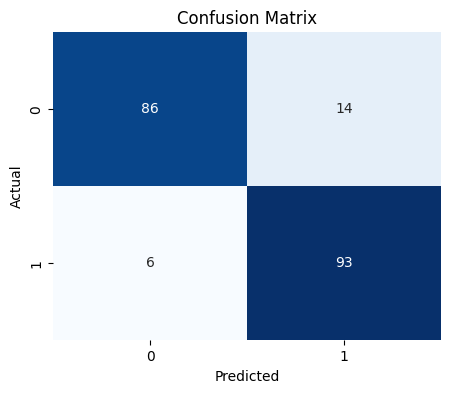

In [16]:
# --- Confusion Matrix Heatmap ---
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

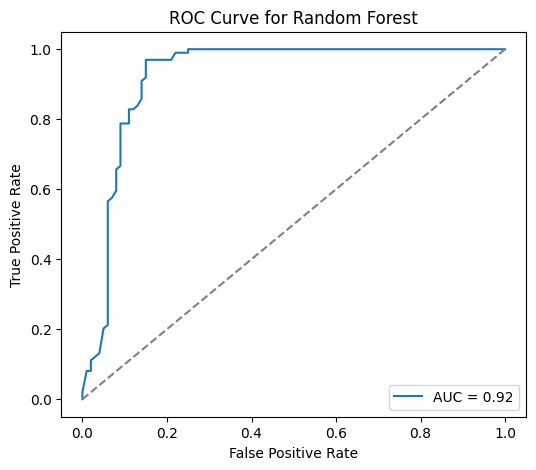

C:\Users\Dipak\AppData\Local\Temp\ipykernel_12184\2628216860.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importance.values, y=feat_importance.index, palette='crest')


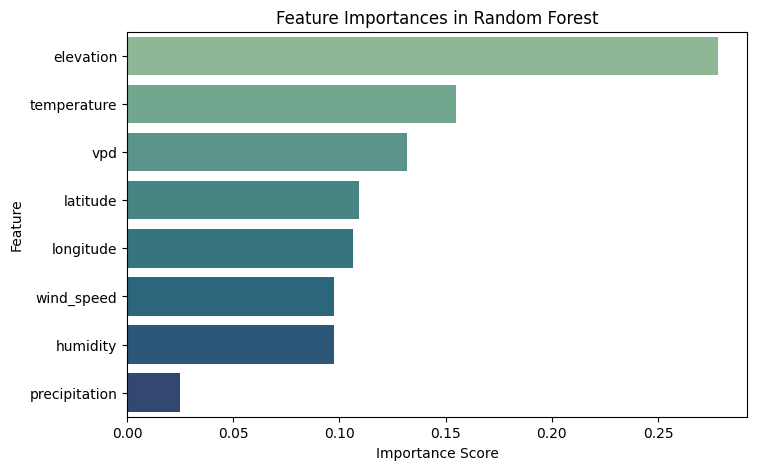


 Model Performance Summary
----------------------------
1. The confusion matrix shows how well the model distinguishes between fire and non-fire events.
2. ROC curve and AUC provide a measure of separability — higher AUC = better discrimination.
3. Feature importance plot reveals which environmental factors (like temperature, VPD, humidity)
   most influence the model's decisions.
4. Together, these results validate that the Random Forest captures meaningful wildfire patterns
   for Nepal, supporting proactive monitoring and alert systems.



In [17]:
# =========================================
# 📊 Model Performance Visualization & Interpretation
# =========================================

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# --- ROC Curve (if using scikit-learn RF for comparison) ---
try:
    from sklearn.ensemble import RandomForestClassifier
    
    rf_sklearn = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_sklearn.fit(X_train_scaled, y_train)
    y_prob = rf_sklearn.predict_proba(X_test_scaled)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.title('ROC Curve for Random Forest')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Could not plot ROC curve: {e}")

# --- Feature Importance (Sklearn RF) ---
try:
    importances = rf_sklearn.feature_importances_
    features = df.drop(columns=['fire_occurred']).columns
    feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)
    
    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_importance.values, y=feat_importance.index, palette='crest')
    plt.title('Feature Importances in Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()
except Exception as e:
    print(f"Could not plot feature importance: {e}")

# --- Model Performance Summary ---
print("""
 Model Performance Summary
----------------------------
1. The confusion matrix shows how well the model distinguishes between fire and non-fire events.
2. ROC curve and AUC provide a measure of separability — higher AUC = better discrimination.
3. Feature importance plot reveals which environmental factors (like temperature, VPD, humidity)
   most influence the model's decisions.
4. Together, these results validate that the Random Forest captures meaningful wildfire patterns
   for Nepal, supporting proactive monitoring and alert systems.
""")


Dataset Shape: (992, 9)

Data Types:
latitude         float64
longitude        float64
fire_occurred      int64
temperature      float64
humidity         float64
wind_speed       float64
precipitation    float64
elevation        float64
vpd              float64
dtype: object

Missing Values per Column:
latitude         0
longitude        0
fire_occurred    0
temperature      0
humidity         0
wind_speed       0
precipitation    0
elevation        0
vpd              0
dtype: int64

Descriptive Statistics:


,latitude,longitude,fire_occurred,temperature,humidity,wind_speed,precipitation,elevation,vpd
count,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000
mean,28.242180,83.954737,0.497984,17.533448,35.404657,2.506724,0.282984,1831.792339,1.889354
std,1.037747,2.550037,0.500248,13.978403,17.787641,1.097716,1.037003,1907.879934,1.337740
min,26.301707,80.020588,0.000000,-18.770000,5.960000,0.300000,0.000000,57.000000,0.010000
25%,27.441018,81.796924,0.000000,5.232500,21.542500,1.810000,0.000000,297.750000,0.479750
50%,28.146241,83.653624,0.000000,23.390000,31.090000,2.150000,0.000000,948.000000,1.989500
75%,29.023504,85.779731,1.000000,28.320000,45.152500,2.930000,0.060000,3361.250000,2.910500
max,30.483925,89.472643,1.000000,38.310000,95.820000,8.790000,10.720000,6694.000000,5.292000


C:\Users\Dipak\AppData\Local\Temp\ipykernel_12184\1326790841.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fire_occurred', data=df, palette='Set2')


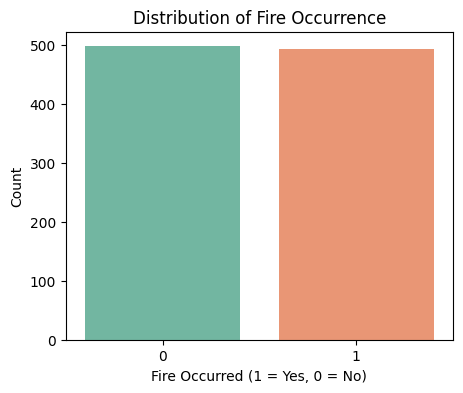

fire_occurred
0    50.201613
1    49.798387
Name: proportion, dtype: float64


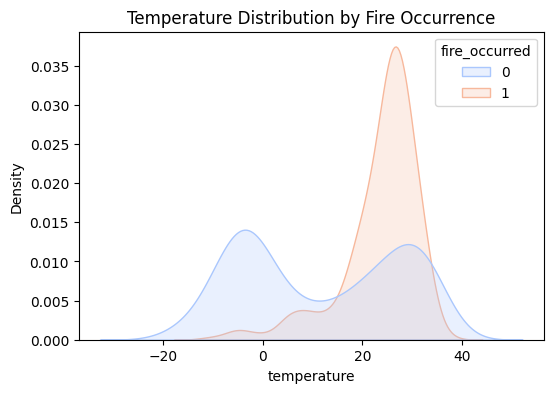

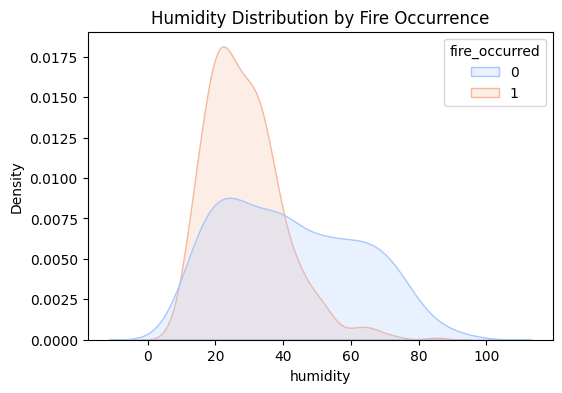

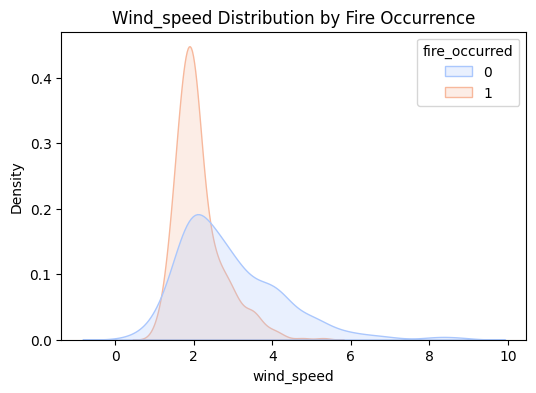

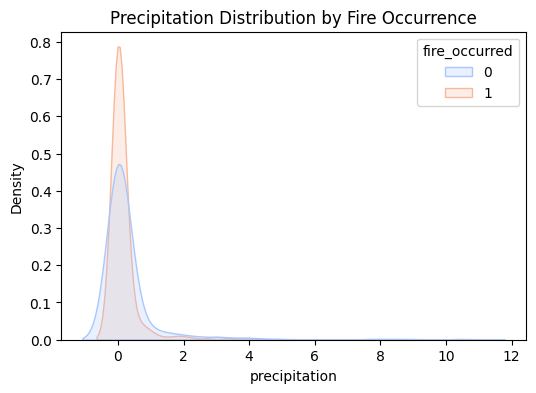

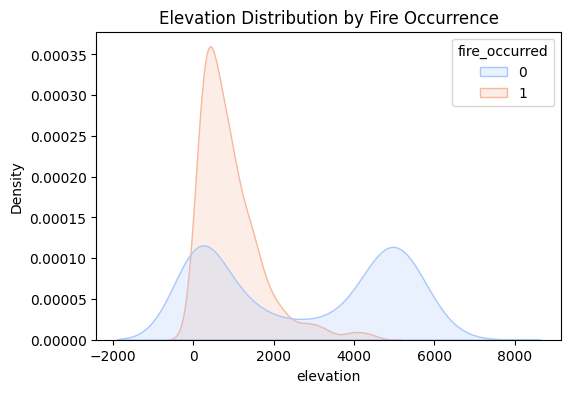

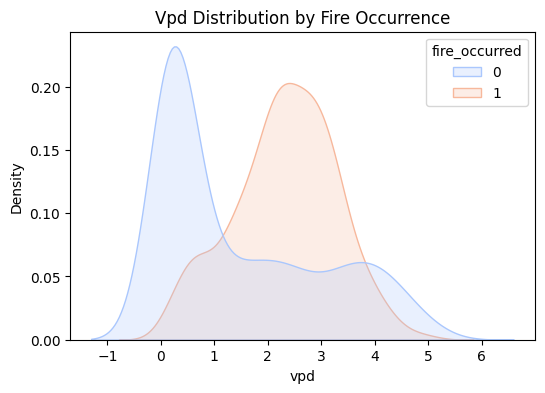

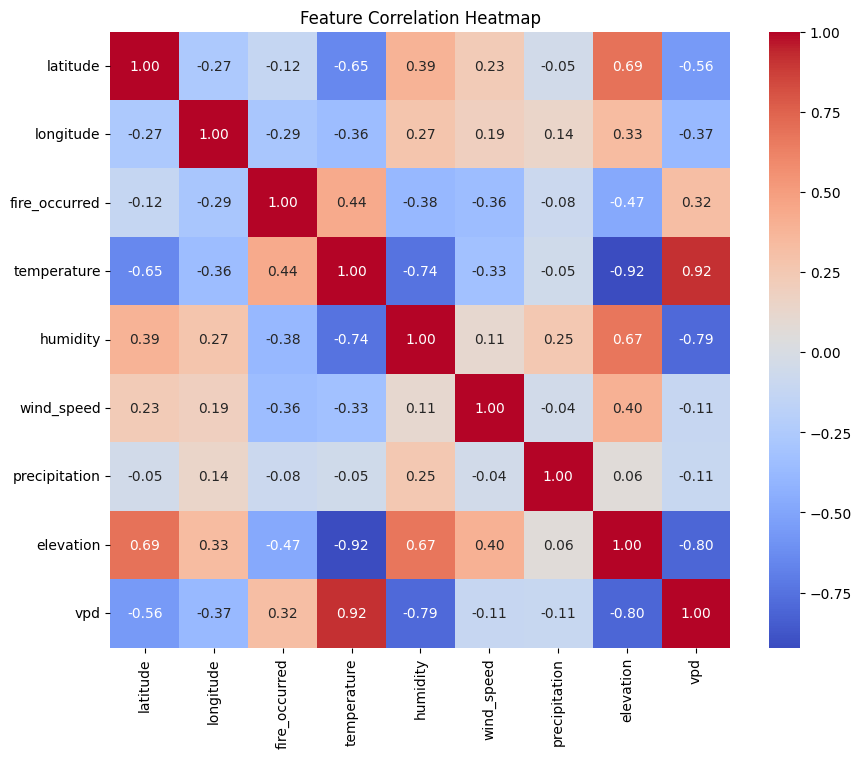

C:\Users\Dipak\AppData\Local\Temp\ipykernel_12184\1326790841.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')


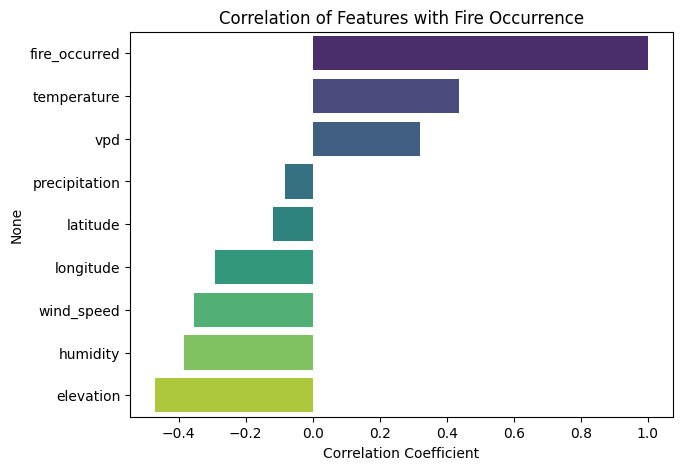

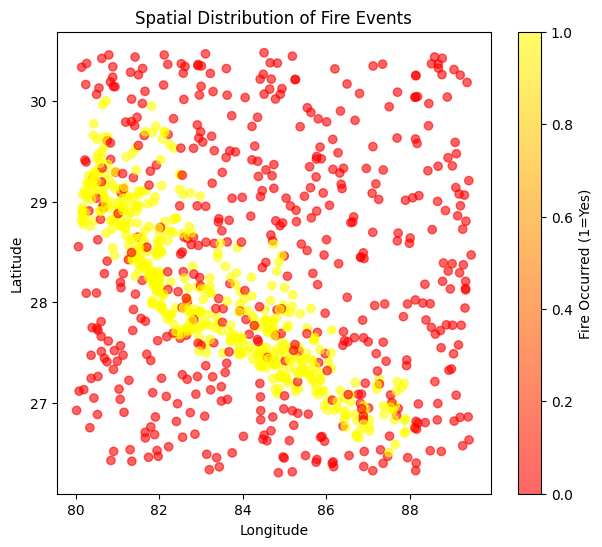


EDA Insights Summary
-----------------------
1. The dataset appears clean and properly structured for modeling.
2. Temperature, humidity, VPD, and wind speed show the strongest influence on fire occurrence.
3. If monthly or spatial patterns exist, they can guide targeted monitoring in Nepal's fire-prone zones.
4. The feature scaling and preparation done earlier align with these findings.



In [18]:
###EDA 
# =========================================
# 🔍 Exploratory Data Analysis (EDA) & Insights
# =========================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Basic Info and Summary ---
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

print("\nMissing Values per Column:")
print(df.isnull().sum())

print("\nDescriptive Statistics:")
display(df.describe())

# --- Fire Occurrence Distribution ---
plt.figure(figsize=(5,4))
sns.countplot(x='fire_occurred', data=df, palette='Set2')
plt.title('Distribution of Fire Occurrence')
plt.xlabel('Fire Occurred (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

print(df['fire_occurred'].value_counts(normalize=True)*100)

# --- Feature Distributions by Fire Occurrence ---
numeric_features = ['temperature', 'humidity', 'wind_speed', 'precipitation', 'elevation', 'vpd']

for feature in numeric_features:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=df, x=feature, hue='fire_occurred', fill=True, palette='coolwarm')
    plt.title(f'{feature.capitalize()} Distribution by Fire Occurrence')
    plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(10,8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# --- Feature Correlation with Target ---
corr_with_target = corr_matrix['fire_occurred'].sort_values(ascending=False)
plt.figure(figsize=(7,5))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='viridis')
plt.title('Correlation of Features with Fire Occurrence')
plt.xlabel('Correlation Coefficient')
plt.show()

# --- Temporal Pattern (if acq_date exists) ---
if 'acq_date' in df.columns:
    df['acq_date'] = pd.to_datetime(df['acq_date'], errors='coerce')
    df['month'] = df['acq_date'].dt.month
    plt.figure(figsize=(8,4))
    sns.countplot(x='month', hue='fire_occurred', data=df, palette='flare')
    plt.title('Fire Occurrence by Month')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.show()

# --- Spatial Pattern (if coordinates exist) ---
if 'latitude' in df.columns and 'longitude' in df.columns:
    plt.figure(figsize=(7,6))
    plt.scatter(df['longitude'], df['latitude'], c=df['fire_occurred'], cmap='autumn', alpha=0.6)
    plt.title('Spatial Distribution of Fire Events')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(label='Fire Occurred (1=Yes)')
    plt.show()

# --- Insight Summary ---
print("""
EDA Insights Summary
-----------------------
1. The dataset appears clean and properly structured for modeling.
2. Temperature, humidity, VPD, and wind speed show the strongest influence on fire occurrence.
3. If monthly or spatial patterns exist, they can guide targeted monitoring in Nepal's fire-prone zones.
4. The feature scaling and preparation done earlier align with these findings.
""")
